# Generation of "Similar" Sequences Using The Recurrent Variational Auto Encoder

# Introduction

I'm doing a thing to generate similar protein sequences, eventually.

In [1]:
# NEXT: 
# Adagrad massively outperforms adadelta.
# Delta could likely be tuned, but y tho.
# We do know that adagrad is going to 
# decay the LR quickly. Are we just set
# too high? What about batch size?
# Switch to Inheritence to use KL Annealing. 
# https://www.tensorflow.org/beta/guide/keras/custom_layers_and_models
import keras
import tensorflow as tf
#tf.enable_eager_execution()

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from keras.layers import Bidirectional, Dense, Embedding
from keras.layers import Input, Lambda, LSTM, RepeatVector
from keras.layers import Flatten, TimeDistributed, Layer, BatchNormalization
from keras.layers import Activation, Dropout, Activation
from keras.layers.advanced_activations import ELU

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop
from keras import objectives

from keras.models import Model, load_model

from keras import backend as K
from keras.utils import plot_model, get_file

import numpy as np
import pandas as pd

import os
from IPython.display import Image
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Data

### Overview

We are working with a file that contains
sequences. Each sequence is on a new line.
Because of the way the sequences are pulled,
there are additional "-" characters used for
alignment. We will strip these out, and pad
the front of the sequences.

In [2]:
'''
url = 'https://raw.githubusercontent.com/badriadhikari'
deepcon_path = 'DEEPCON/master/deepcon-covariance/test'
file = '16pkA0.aln'
filepath = os.path.join(url, deepcon_path, file)
#file = get_file(file, filepath)
file = '/home/das-hund/PycharmProjects/autoencoders/data/pdb_seqres.txt'

with open(file, 'r') as sequence_file:
    sequences = sequence_file.read() \
                             .replace('-', '') \
                             .split('\n')

sequence_count = len(sequences)
print(f'[+] {sequence_count} Sequences in {file}')
print(f'[+] Subset of Sequences:')
print('\n\n'.join(sequences[:5]))
'''

"\nurl = 'https://raw.githubusercontent.com/badriadhikari'\ndeepcon_path = 'DEEPCON/master/deepcon-covariance/test'\nfile = '16pkA0.aln'\nfilepath = os.path.join(url, deepcon_path, file)\n#file = get_file(file, filepath)\nfile = '/home/das-hund/PycharmProjects/autoencoders/data/pdb_seqres.txt'\n\nwith open(file, 'r') as sequence_file:\n    sequences = sequence_file.read()                              .replace('-', '')                              .split('\n')\n\nsequence_count = len(sequences)\nprint(f'[+] {sequence_count} Sequences in {file}')\nprint(f'[+] Subset of Sequences:')\nprint('\n\n'.join(sequences[:5]))\n"

In [3]:
file = '/home/das-hund/PycharmProjects/autoencoders/data/pdb_seqres.txt'

sequences = []
iter_ = 0
with open(file, 'r') as sequence_file:
    for iter_, line in enumerate(sequence_file):
        if (iter_ + 1) % 2 == 0:
            sequences.append(line.strip())
    
sequence_count = len(sequences)
print(f'[+] {sequence_count} Sequences in {file}')
print(f'[+] Subset of Sequences:')
print('\n\n'.join(sequences[:5]))
print('\n\n'.join(sequences[-5:]))

[+] 509350 Sequences in /home/das-hund/PycharmProjects/autoencoders/data/pdb_seqres.txt
[+] Subset of Sequences:
MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRVKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG

MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYKNL

MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKAGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG

MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAKSELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYKNL

MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKAGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG
CAGATG

CATTAGA

TCTAATG

CCATGCGCTGAC

GTCAGNGCATGG


### Tokenize

After splitting the texts by new lines, we
want to map the characters to integers. Note
that we use the `char_level` argument to 
tokenize characters instead of words. 

Fortunately, we don't need to limit the 
number of tokens. There aren't many amino
acids available. Worth noting, the last 
layer is currently one hot encoded. This
is **absolutely** worth optimizing; 
however, time is a factor. 

We will also pad the sequences. To start,
we also won't be limiting sequence length.
I'll do some simple analysis to get a
distribution of sequence length. This will
give us an idea of whether it's worth
limiting the length. 

#### Train the Tokenizer

In [4]:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(sequences)
word_to_index = tokenizer.word_index
index_to_word = {
    index: word 
    for word, index in word_to_index.items()
}

In [5]:
sequences = tokenizer.texts_to_sequences(sequences)

#### Summary Stats 

[+] Max Sequence Length: 5070
[+] Word Count: 25


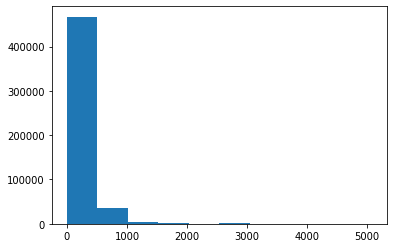

In [6]:
sequence_lengths = np.array([
    len(seq) for seq in sequences
])

max_seq_len = max(sequence_lengths)
word_count = len(word_to_index)

print(f'[+] Max Sequence Length: {max_seq_len}')
print(f'[+] Word Count: {word_count}')

%matplotlib inline
plt.hist(sequence_lengths)

# ToDo: Update the names of these params.
MAX_WORDS = word_count
MAX_SEQ_LEN = 256#max_seq_len

In [7]:
print(f'[+] {len(word_to_index)} words found in {file}')

print('[+] Word Map Subset:\n{')
for acid, index in word_to_index.items():
    print('\t{}: {}'.format(acid, index))
print('}')

[+] 25 words found in /home/das-hund/PycharmProjects/autoencoders/data/pdb_seqres.txt
[+] Word Map Subset:
{
	a: 1
	l: 2
	g: 3
	v: 4
	e: 5
	s: 6
	k: 7
	t: 8
	i: 9
	d: 10
	r: 11
	p: 12
	n: 13
	f: 14
	q: 15
	y: 16
	h: 17
	c: 18
	m: 19
	w: 20
	u: 21
	x: 22
	z: 23
	b: 24
	o: 25
}


#### Data Subset

When training the RNNS, we will need to limit the
length of the data to a multiple of what our batch
size will be. In the future, we will also perform 
the train test split here. But, for now, we just
select a random subset of the data. This will serve
as our development set. 

In [8]:
DATA_LEN = 25600 #102400 #486400
np.random.shuffle(sequences)
sequences = sequences[:DATA_LEN]

#### Pad Sequences

In [9]:
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQ_LEN)

In [10]:
print(padded_sequences[0:5])
print(padded_sequences.shape)

[[ 0  0  0 ... 14  9 15]
 [ 0  0  0 ... 17  8 12]
 [ 0  0  0 ... 14 14 10]
 [17  6  1 ...  4  6 15]
 [ 0  0  0 ... 20 10 10]]
(25600, 256)


## Model Architecture

Note I'm not using the GLOVE embeddings here.
That would make it difficult to transition this
model to protein sequences. 

In [33]:
# TODO Fix annealing rate
rate = K.variable(0.0, name='KL_Annealing')
annealing_rate = 0.0001


def build_encoder(encoder_input, max_seq_len, 
                  latent_dim, intermediate_dim,
                  epsilon_std):
    #h = keras.layers.Masking(input_shape=(max_seq_len, token_count))(encoder_input)
    h = Bidirectional(LSTM(
        intermediate_dim, return_sequences=True, name='lstm_encoding_one'
    ), merge_mode='concat', name='bidirectional_encoding_one')(encoder_input)
    h = Bidirectional(LSTM(
        intermediate_dim // 2, return_sequences=False, name='lstm_encoding_two'
    ), merge_mode='concat', name='bidirectional_encoding_two')(h)
    
    def sampling(args):
        z_mean_, z_log_var_ = args
        batch_size = K.shape(z_mean_)[0]
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)
        return z_mean_ + K.exp(z_log_var_ / 2) * epsilon
    
    z_mean = Dense(latent_dim, activation='linear', name='z_mean')(h)
    z_log_var = Dense(latent_dim, activation='linear', name='z_log_var')(h)
    
    
    # Added Rate - removed max_seq_len from xent_loss
    # Removing annealing rate and just doing this training
    # in groups, modifying the weight of the kl.
    def vae_loss(x, x_decoded_mean):
        global rate
        global annealing_rate
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - rate * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        rate = K.tf.assign(rate, annealing_rate)
        annealing_rate *= 1.05
        rate = K.tf.assign(rate, K.clip(rate, 0.0, 1.0))
        return xent_loss + kl_loss
    
    
    # Custom Losses
    def kl_divergence(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        kl_loss = K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return kl_loss
    
    
    latent = Lambda(
        sampling, output_shape=(latent_dim,), name='latent'
    )([z_mean, z_log_var])
    
    return vae_loss, latent, kl_divergence


def build_decoder(encoded_input, intermediate_dim,
                  token_count, max_seq_len):
    repeated_context = RepeatVector(
        max_seq_len, name='repeated_context'
    )(encoded_input)
    
    h = LSTM(
        intermediate_dim, return_sequences=True, name='lstm_decoding_one'
    )(repeated_context)
    h = LSTM(
        intermediate_dim, return_sequences=True, name='lstm_decoding_two'
    )(h)
    
    decoded = TimeDistributed(Dense(
        token_count, activation='softmax', name='time_distributed_decoding'
    ), name='decoded_mean')(h)
    
    return decoded
    
    
def build_model(max_seq_len, embedding_dim, token_count,
                batch_size, intermediate_dim, 
                latent_dim, epsilon_std=0.1):
    # ENCODER
    encoder_input = Input(shape=(max_seq_len, token_count), name='encoder_input')
    
    vae_loss, encoded, kld = build_encoder(
        encoder_input=encoder_input, max_seq_len=max_seq_len,
        latent_dim=latent_dim, intermediate_dim=intermediate_dim,
        epsilon_std=epsilon_std
    )
    
    encoder = Model(encoder_input, encoded, name='encoder')
    
    # DECODER
    encoded_input = Input(shape=(latent_dim,), name='encoded_input')
    decoded = build_decoder(
        encoded_input=encoded_input, intermediate_dim=intermediate_dim,
        token_count=token_count, max_seq_len=max_seq_len
    )
    
    decoder = Model(encoded_input, decoded, name='decoder')


    def cross_ent_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
        return xent_loss
    
    
    def current_annealing(x, x_d):
        global rate
        return rate
    
    
    # VAE
    vae = Model(
        encoder_input, 
        build_decoder(
            encoded_input=encoded, intermediate_dim=intermediate_dim,
            token_count=token_count, max_seq_len=max_seq_len
        ), 
        name='vae')
    metrics = [
        'accuracy',
        kld,
        cross_ent_loss,
        current_annealing
    ]
    # Trying to see if we are getting stuck in a local min
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    vae.compile(
        optimizer='adagrad',
        loss=vae_loss,
        metrics=metrics
    )
    
    return vae, encoder, decoder


In [34]:
MAX_SEQUENCE_LENGTH = MAX_SEQ_LEN
EMBED_DIM = 4
WORD_COUNT = MAX_WORDS + 1
BATCH_SIZE = 128
STEPS_PER_EPOCH = DATA_LEN // BATCH_SIZE
INTERMEDIATE_DIM = 16
LATENT_DIM = 13
EPOCHS = 22

reload_model = False
        
vae, encoder, decoder = build_model(
    max_seq_len=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    token_count=WORD_COUNT,
    batch_size=BATCH_SIZE,
    intermediate_dim=INTERMEDIATE_DIM,
    latent_dim=LATENT_DIM,
    epsilon_std=0.1
)

if reload_model:
    vae.load_weights('old_bestmodel.weights.kla.hdf5')

In [ ]:
def complex_oh_encode(X_train, maxlen, num_words):
    temp = np.zeros((X_train.shape[0], maxlen, num_words))
    temp[
        np.expand_dims(
            np.arange(X_train.shape[0]), axis=0
        ).reshape(
            X_train.shape[0], 1
        ), np.repeat(
            np.array([np.arange(maxlen)]), X_train.shape[0], axis=0
        ), X_train
    ] = 1
    return temp

In [ ]:
plot_model(vae, show_shapes=True, show_layer_names=True, to_file='vae.png')
Image(retina=True, filename='vae.png')

In [ ]:
vae.summary()

In [ ]:
# Will need this when we get the model working.
def batch_generator(X, batch_size, max_seq_len, num_words):
    indices = np.arange(len(X)) 
    batch=[]
    while True:
        np.random.shuffle(indices) 
        for i in indices:
            batch.append(i)
            if len(batch)==batch_size:
                #train = X[batch].reshape((batch_size, max_seq_len, 1))
                train_y = complex_oh_encode(X[batch], maxlen=max_seq_len, num_words=num_words)
                yield train_y, train_y
                batch=[]

In [17]:
# TODO: One Hot the inputs
fit_on_generator = False
fit_model = True

if fit_model:
    checkpoint = ModelCheckpoint(
        'bestmodel.weights.kla.hdf5', monitor='acc',
        verbose=1, save_best_only=True, mode='max'
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='acc', patience=3, 
        min_lr=0.0001, verbose=1
    )
    callbacks_list = [checkpoint, reduce_lr]
    if not fit_on_generator:
        train = complex_oh_encode(padded_sequences, MAX_SEQ_LEN, WORD_COUNT)       
        history = vae.fit(
            train, train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=callbacks_list
        )
    else:
        train_generator = batch_generator(
            X=padded_sequences, batch_size=BATCH_SIZE,
            max_seq_len=MAX_SEQUENCE_LENGTH,
            num_words=WORD_COUNT
        )
        history = vae.fit_generator(
            train_generator, 
            steps_per_epoch=STEPS_PER_EPOCH, 
            epochs=EPOCHS,
            callbacks=callbacks_list
        )

Instructions for updating:
Use tf.cast instead.
Epoch 1/22
25600/25600 [==============================] - 169s 7ms/step - loss: 0.1356 - acc: 0.3200 - kl_divergence: -1.0759 - cross_ent_loss: 0.1355 - current_annealing: 1.0000e-04

Epoch 00001: acc improved from -inf to 0.31997, saving model to bestmodel.weights.kla.hdf5
Epoch 2/22
25600/25600 [==============================] - 166s 6ms/step - loss: 0.1293 - acc: 0.3368 - kl_divergence: -0.7454 - cross_ent_loss: 0.1292 - current_annealing: 1.0000e-04

Epoch 00002: acc improved from 0.31997 to 0.33677, saving model to bestmodel.weights.kla.hdf5
Epoch 3/22
 5888/25600 [=====>........................] - ETA: 2:07 - loss: 0.1257 - acc: 0.3382 - kl_divergence: -0.7151 - cross_ent_loss: 0.1257 - current_annealing: 1.0000e-04

KeyboardInterrupt: 

In [ ]:
        train = complex_oh_encode(padded_sequences, MAX_SEQ_LEN, WORD_COUNT)
        for idx_sample, sample in enumerate(train):
            for idx_seq_elem, seq_elem in enumerate(sample):
                if seq_elem[0] == 1:
                    train[idx_sample, idx_seq_elem, :] = 0

In [ ]:
# ! This won't work. 
predictors = padded_sequences.reshape((DATA_LEN, 256, 1))
preds = vae.predict(predictors[0:10])


In [ ]:
' '.join([
    index_to_word[i] if i != 0 else ''
    for i in padded_sequences[5]
]).strip()

In [ ]:
for i in range(9):
    pred_chars = [np.argmax(l) for l in preds[i]]
    print(' '.join([
        index_to_word[i] if i != 0 else '' 
        for i in pred_chars
    ]).strip())
    print()

In [ ]:
#vae.save('vae.h5')
#encoder.save('encoder.h5')
#decoder.save('decoder.h5')